## Supporting code:

### Identification of the two compact objects in gravitational-wave binaries

*Gerosa et al. (2024)*

This notebook provides our implementation of semi-supervised clustering to identify objects in pairs of samples.  In particular, we implement the toy model presented in the Supplemental Material of Gerosa et al. (2024).

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sklearn.preprocessing
import sklearn.metrics
import sklearn.cluster

plt.rcParams['figure.figsize'] = [6, 6]

Here are the core functions...

In [66]:
def constrain_efficiency(labels,cannotlink):
    '''
    After the clustering has been done, use this to compute the fractions of satisfied constraints. 
    This must be equal to n_samples, otherwise something is not working properly.
    '''
    
    ok = np.sum(labels[cannotlink[:,0]] != labels[cannotlink[:,1]])
    # Fraction of satisfied constraints
    efficiency= ok/len(cannotlink)
    return efficiency

def comparelabels(labels1,labels2):
    '''
    Compare two sets of labels and return the fraction eta have been left unchanged identical.
    '''
    return max(np.sum(labels1==labels2),np.sum(labels1!=labels2)) / len(labels1)

def clusterme(X1,X2,check=True):
    '''
    This is where the actual clustering happens.
    X1 and X2 refer to the two objects and must be of shape (n_samples, n_features)
    '''

    # Put the two objects togheter
    X = np.concatenate([X1,X2])
    
    # These are samples that must belong to two clusters
    n_samples = X1.shape[0]
    cannotlink = np.array([np.arange(n_samples), np.arange(n_samples)+n_samples]).T

    # Sample by sample labeling using the first feature (typically the mass)
    firstfeaturelabels = X1[:,0]>X2[:,0]
    firstfeaturelabels= np.concatenate([firstfeaturelabels,~firstfeaturelabels])
    
    # Prescaling
    scaler = sklearn.preprocessing.StandardScaler().fit(X)
    Xnorm = scaler.transform(X) 

    # Affinity matrix
    distance = sklearn.metrics.pairwise.pairwise_distances(Xnorm, metric='l1',n_jobs=-1)
    bandwidth = 1e6
    affinity = np.exp(- (distance ** 2)/ (2 * bandwidth**2))

    # Force affinity=0 for the two objects in the same posterior sample
    affinity[cannotlink[:,0],cannotlink[:,1]]=0
    affinity[cannotlink[:,1],cannotlink[:,0]]=0

    # Define and run clustering
    clustering = sklearn.cluster.SpectralClustering(n_clusters=2,
                                                    affinity='precomputed',
                                                    assign_labels='cluster_qr',
                                                    n_jobs=-1)
    clusterlabels = clustering.fit_predict(affinity)

    # Order the labels by the median of the first feature
    if np.median(X[:,0][clusterlabels==0]) > np.median(X[:,0][clusterlabels==1]):
        clusterlabels=np.logical_not(clusterlabels)

    # Fraction of satisfied constraints
    satisfiedconstaints = constrain_efficiency(clusterlabels,cannotlink)
    if check:
        assert satisfiedconstaints == 1

    # Use "1" and "2" instead of "1" and "0" because it is more common in GW astronomy.
    firstfeaturelabels = np.where( firstfeaturelabels.astype(int) ==0, 2, 1)
    clusterlabels = np.where( clusterlabels.astype(int) ==0, 2, 1)

    return X, firstfeaturelabels.astype(int), clusterlabels.astype(int)

... and here is a working example.

In [67]:
#Number of posterior samples
N=500
# Assume gaussian distributions in two variables
deltamu = np.array([0.5,2.5]) # Change these number to explore!

mu1= + deltamu
mu2= - deltamu
cov = [[1,0],[0,1]]
X1 = scipy.stats.multivariate_normal(mean=mu1, cov=cov).rvs(N)
X2 = scipy.stats.multivariate_normal(mean=mu2, cov=cov).rvs(N)
truelabels = np.concatenate([np.ones(N),2*np.ones(N)])

# Run clustering
X, firstfeaturelabels,clusterlabels = clusterme(X1,X2)

These are the true labels (in practice you never have them)

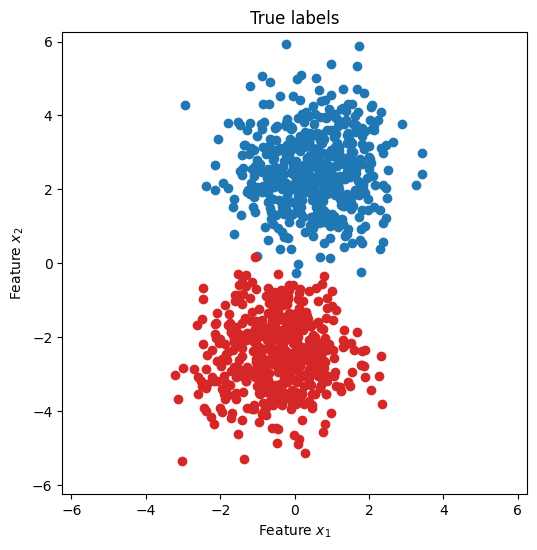

In [68]:
plt.scatter(X[:,0][truelabels==1],X[:,1][truelabels==1],c='C0')
plt.scatter(X[:,0][truelabels==2],X[:,1][truelabels==2],c='C3')
plt.xlim(-2.5*max(deltamu),2.5*max(deltamu))
plt.ylim(-2.5*max(deltamu),2.5*max(deltamu))
plt.xlabel("Feature $x_1$")
plt.ylabel("Feature $x_2$")
plt.title("True labels");


Label the samples using the first feature only

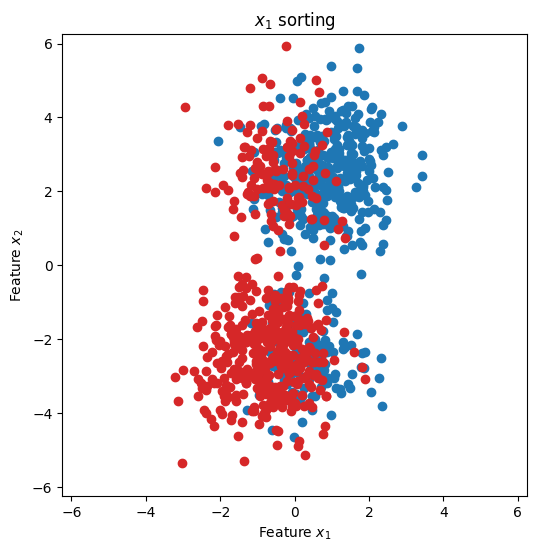

In [69]:
plt.scatter(X[:,0][firstfeaturelabels==1],X[:,1][firstfeaturelabels==1],c='C0')
plt.scatter(X[:,0][firstfeaturelabels==2],X[:,1][firstfeaturelabels==2],c='C3')
plt.xlim(-2.5*max(deltamu),2.5*max(deltamu))
plt.ylim(-2.5*max(deltamu),2.5*max(deltamu))
plt.xlabel("Feature $x_1$")
plt.ylabel("Feature $x_2$")
plt.title("$x_1$ sorting");

Label the samples using semi-supervised clustering

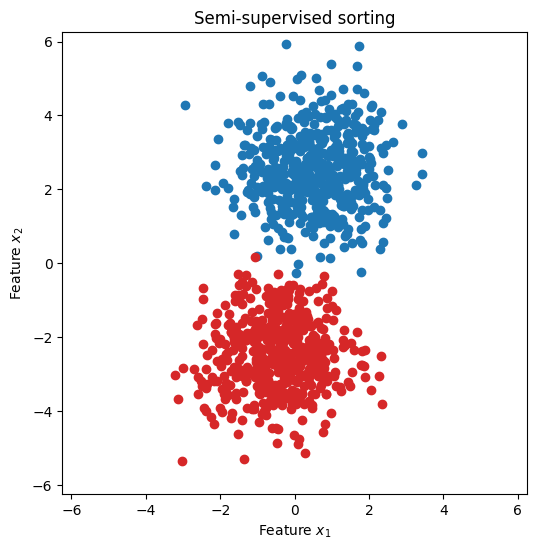

In [70]:
plt.scatter(X[:,0][clusterlabels==1],X[:,1][clusterlabels==1],c='C0')
plt.scatter(X[:,0][clusterlabels==2],X[:,1][clusterlabels==2],c='C3')
plt.xlim(-2.5*max(deltamu),2.5*max(deltamu))
plt.ylim(-2.5*max(deltamu),2.5*max(deltamu))
plt.xlabel("Feature $x_1$")
plt.ylabel("Feature $x_2$")
plt.title("Semi-supervised sorting");

Fractions of equivalent samples in each set of labels:

In [71]:
print("True vs. x1 sorting:\t\t\t", comparelabels(truelabels,firstfeaturelabels))
print("True vs. semi-sup. sorting:\t\t", comparelabels(truelabels,clusterlabels))
print("x1 sorting vs. semi-sup. sorting:\t", comparelabels(firstfeaturelabels,clusterlabels))

True vs. x1 sorting:			 0.74
True vs. semi-sup. sorting:		 1.0
x1 sorting vs. semi-sup. sorting:	 0.74


Careful when computing more complex estimators, as this requires unpackaging the arrays to make sure that the original pairs are respected. For instance: 

In [72]:
# This is just a sanity check
X1test = np.where( (truelabels[N:] == 1)[:, np.newaxis], X[:][N:], X[:][:N])
X2test = np.where( (truelabels[N:] == 2)[:, np.newaxis], X[:][N:], X[:][:N])
assert np.all(X1test==X1)
assert np.all(X2test==X2)


X1firstfeature = np.where( (firstfeaturelabels[N:] == 1)[:, np.newaxis], X[:][N:], X[:][:N])
X2firstfeature = np.where( (firstfeaturelabels[N:] == 2)[:, np.newaxis], X[:][N:], X[:][:N])

X1cluster = np.where( (clusterlabels[N:] == 1)[:, np.newaxis], X[:][N:], X[:][:N])
X2cluster = np.where( (clusterlabels[N:] == 2)[:, np.newaxis], X[:][N:], X[:][:N])

For instance, this computes ratio of the first features of object 2 and that of object 1 (in GW astronomy, this is like the mass ratio q)

In [73]:
# This would be wrong:
#ratio = X[:,0][firstfeaturelabels==2] / X[:,0][firstfeaturelabels==1]
# Instead do the following...


# Using first-feature sorting
ratiof = X2firstfeature[:,0] / X1firstfeature[:,0]
# Using semi-supervised sorting
ratioc = X2cluster[:,0] / X1cluster[:,0]

# If you plot them one vs the other, it's either y=x or y=1/x when labels were flipped
#plt.scatter(ratiof, ratioc)
#plt.xlim(-10,10)
#plt.ylim(-10,10)

Any estimator that is manifestly invariant under a "1" <--> "2" relabling must not be impact. For, instance, take the sum of the second features (in GW astronomy this would be like chi1+chi2)

In [74]:
# This would be wrong:
# assert np.all( X[:,1][firstfeaturelabels==1] + X[:,1][firstfeaturelabels==2] == X[:,1][clusterlabels==1] + X[:,1][clusterlabels==2] )
# Instead do the following...

assert np.all( X1firstfeature[:,1] + X2firstfeature[:,1] == X1cluster[:,1] + X2cluster[:,1] )